In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
df = pd.read_csv('dataset/class_text.csv')
print(df.document_page_type.unique())
df.head()

['tech' 'entertainment' 'politics' 'sport' 'business']


,Unnamed: 0,id,file_path,document_page_type,text,file_name
0,0,1.0,dataset/bbc/tech/316.txt,tech,More women turn to net security\n\nOlder peopl...,316.txt
1,1,2.0,dataset/bbc/tech/275.txt,tech,Souped-up wi-fi is on the horizon\n\nSuper hig...,275.txt
2,2,3.0,dataset/bbc/tech/020.txt,tech,Security scares spark browser fix\n\nMicrosoft...,020.txt
3,3,4.0,dataset/bbc/tech/212.txt,tech,"Lifestyle 'governs mobile choice'\n\nFaster, b...",212.txt
4,4,5.0,dataset/bbc/tech/253.txt,tech,Fast lifts rise into record books\n\nTwo high-...,253.txt


In [4]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['More women turn to net security Older people and women are increasingly '
 'taking charge of protecting home computers against malicious net attacks, '
 'according to a two-year study. The number of women buying programs to '
 'protect PCs from virus, spam and spyware attacks rose by 11.2% each year '
 'between 2002 and 2004. The study, for net security firm Preventon, shows '
 'that security messages are reaching a diversity of surfers. It is thought '
 'that 40% of those buying home net security programs are retired. For the '
 'last three years, that has gone up by an average of 13.2%. But more retired '
 'women (53%) were buying security software than retired men. The research '
 'reflects the changing stereotype and demographics of web users, as well as '
 'growing awareness of the greater risks that high-speed broadband net '
 'connections can pose to surfers. The study predicts that 40% of all home PC '
 'net security buyers will be women in 2005. They could even overtake men 

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['more', 'women', 'turn', 'to', 'net', 'security', 'older', 'people', 'and', 'women', 'are', 'increasingly', 'taking', 'charge', 'of', 'protecting', 'home', 'computers', 'against', 'malicious', 'net', 'attacks', 'according', 'to', 'two', 'year', 'study', 'the', 'number', 'of', 'women', 'buying', 'programs', 'to', 'protect', 'pcs', 'from', 'virus', 'spam', 'and', 'spyware', 'attacks', 'rose', 'by', 'each', 'year', 'between', 'and', 'the', 'study', 'for', 'net', 'security', 'firm', 'preventon', 'shows', 'that', 'security', 'messages', 'are', 'reaching', 'diversity', 'of', 'surfers', 'it', 'is', 'thought', 'that', 'of', 'those', 'buying', 'home', 'net', 'security', 'programs', 'are', 'retired', 'for', 'the', 'last', 'three', 'years', 'that', 'has', 'gone', 'up', 'by', 'an', 'average', 'of', 'but', 'more', 'retired', 'women', 'were', 'buying', 'security', 'software', 'than', 'retired', 'men', 'the', 'research', 'reflects', 'the', 'changing', 'stereotype', 'and', 'demographics', 'of', 'web

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod)
print(trigram_mod[bigram_mod[data_words[0]]])

['more', 'women', 'turn', 'to', 'net', 'security', 'older', 'people', 'and', 'women', 'are', 'increasingly', 'taking', 'charge', 'of', 'protecting', 'home', 'computers', 'against', 'malicious', 'net', 'attacks', 'according', 'to', 'two', 'year', 'study', 'the', 'number', 'of', 'women', 'buying', 'programs', 'to', 'protect', 'pcs', 'from', 'virus', 'spam', 'and', 'spyware', 'attacks', 'rose', 'by', 'each', 'year', 'between', 'and', 'the', 'study', 'for', 'net', 'security', 'firm', 'preventon', 'shows', 'that', 'security', 'messages', 'are', 'reaching', 'diversity', 'of', 'surfers', 'it', 'is', 'thought', 'that', 'of', 'those', 'buying', 'home', 'net', 'security', 'programs', 'are', 'retired', 'for', 'the', 'last', 'three', 'years', 'that', 'has', 'gone', 'up', 'by', 'an', 'average', 'of', 'but', 'more', 'retired', 'women', 'were', 'buying', 'security', 'software', 'than', 'retired', 'men', 'the', 'research', 'reflects', 'the', 'changing', 'stereotype', 'and', 'demographics', 'of', 'web'

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# import sys
# !{sys.executable} -m pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import spacy as spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['woman', 'turn', 'net', 'security', 'old', 'people', 'woman', 'increasingly', 'take', 'charge', 'protect', 'home', 'computer', 'malicious', 'net', 'attack', 'accord', 'year', 'study', 'number', 'woman', 'buy', 'program', 'protect', 'virus', 'spam', 'spyware', 'attack', 'rise', 'year', 'study', 'net', 'security', 'firm', 'preventon', 'show', 'security', 'message', 'reach', 'diversity', 'surfer', 'think', 'buy', 'home', 'net', 'security', 'program', 'retire', 'last', 'year', 'go', 'average', 'retired', 'woman', 'buy', 'security', 'software', 'retire', 'man', 'research', 'reflect', 'change', 'stereotype', 'demographic', 'web', 'user', 'well', 'grow', 'awareness', 'great', 'risk', 'broadband', 'net', 'connection', 'pose', 'surfer', 'study', 'predict', 'home', 'pc', 'net', 'security', 'buyer', 'woman', 'even', 'overtake', 'man', 'main', 'buyer', 'current', 'rate', 'persist', 'accord', 'research', 'think', 'old', 'people', 'become', 'vigilant', 'protect', 'tend', 'cautious', 'want', 'insur

In [9]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 4), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 2), (12, 1), (13, 5), (14, 3), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 1), (25, 3), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 3), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 5), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 4), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 13), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 3), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 5), (102, 1), (103, 2), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 1), (110, 6

In [10]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.057*"say" + 0.040*"mr" + 0.033*"government" + 0.016*"dollar" + '
  '0.014*"economic" + 0.013*"oil" + 0.012*"state" + 0.012*"claim" + '
  '0.011*"rule" + 0.010*"minister"'),
 (1,
  '0.039*"holiday" + 0.028*"mail" + 0.025*"internet" + 0.023*"crude" + '
  '0.022*"outlook" + 0.020*"online" + 0.017*"computer" + 0.015*"security" + '
  '0.014*"acquisition" + 0.014*"software"'),
 (2,
  '0.042*"say" + 0.017*"firm" + 0.017*"company" + 0.016*"new" + 0.012*"make" + '
  '0.011*"deal" + 0.011*"offer" + 0.011*"also" + 0.010*"pay" + 0.008*"people"'),
 (3,
  '0.017*"noise" + 0.010*"blast" + 0.008*"jim" + 0.006*"boat" + 0.006*"demise" '
  '+ 0.005*"warner" + 0.005*"rd" + 0.004*"blade" + 0.004*"partisan" + '
  '0.004*"menu"'),
 (4,
  '0.173*"airline" + 0.080*"flight" + 0.058*"saturday" + 0.039*"employee" + '
  '0.038*"suspend" + 0.028*"wage" + 0.026*"employment" + 0.026*"delta" + '
  '0.023*"conflict" + 0.018*"wing"'),
 (5,
  '0.100*"impose" + 0.013*"musical" + 0.006*"wong" + 0.005*"abbott" + '

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.948685505179276

Coherence Score:  0.4468473887275787


In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.323277 -0.128081       1        1  21.770415
2      0.349420  0.017300       2        1  21.147701
0      0.297006 -0.053916       3        1  14.436772
12     0.304815 -0.069467       4        1  13.199017
6      0.329374  0.132754       5        1  10.043600
10     0.217630 -0.090453       6        1   6.624330
7     -0.019543 -0.033809       7        1   4.093511
11    -0.103055  0.017796       8        1   2.512627
1     -0.102014 -0.014598       9        1   2.265006
14     0.058046  0.379034      10        1   2.169488
4     -0.139042 -0.007416      11        1   0.403567
8     -0.158839 -0.015204      12        1   0.246972
17    -0.161492 -0.015691      13        1   0.207839
9     -0.170820 -0.018220      14        1   0.192105
18    -0.168986 -0.010426      15        1   0.165017
13    -0.170799 -0.017784      16        1   0.129312
19    -0.171100 -0.018164      17        1   0.109240
3     -0.171467 -0.017756      18        1   0.103831
16    -0.171176 -0.018069      19        1   0.100149
5     -0.171234 -0.017832      20        1   0.079499, topic_info=                      Term          Freq         Total Category  logprob  \
1936                  sale   1529.000000   1529.000000  Default  30.0000   
80                      mr   2953.000000   2953.000000  Default  29.0000   
133                    say  11116.000000  11116.000000  Default  28.0000   
239             government   2038.000000   2038.000000  Default  27.0000   
178                   year   3976.000000   3976.000000  Default  26.0000   
...                    ...           ...           ...      ...      ...   
20483                yukos      0.012898      1.149351  Topic20 -10.1885   
20746  exchange_commission      0.012898      1.149162  Topic20 -10.1885   
7019                unfair      0.012898      1.149106  Topic20 -10.1885   
16098                relax      0.012898      1.149091  Topic20 -10.1885   
20611             worldcom      0.012898      1.149175  Topic20 -10.1885   

       loglift  
1936   30.0000  
80     29.0000  
133    28.0000  
239    27.0000  
178    26.0000  
...        ...  
20483   2.6473  
20746   2.6475  
7019    2.6475  
16098   2.6475  
20611   2.6475  

[903 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4693     20  0.715504       abbott
4733      7  0.983573      absence
0         2  0.994104       access
4256      3  0.996546       accuse
337       9  0.996392  acquisition
...     ...       ...          ...
178       4  0.044761         year
178       5  0.504195         year
178       6  0.058844         year
178       7  0.009556         year
3342     10  0.984109          yen

[1102 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 3, 1, 13, 7, 11, 8, 12, 2, 15, 5, 9, 18, 10, 19, 14, 20, 4, 17, 6])

In [14]:
import os
os.environ.update({'MALLET_HOME':r'mallet-2.0.8/bin/mallet'})
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=16, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('film', 0.047120857047204555),
   ('good', 0.022849012387010377),
   ('award', 0.022053900234348844),
   ('star', 0.019333779712085705),
   ('director', 0.014856042852360227),
   ('include', 0.011298962169400736),
   ('actor', 0.009625041848008034),
   ('year', 0.009373953799799129),
   ('prize', 0.00849514563106796),
   ('role', 0.00849514563106796)]),
 (9,
  [('mr', 0.018125032000409606),
   ('company', 0.016435410373252777),
   ('case', 0.01474578874609595),
   ('court', 0.013824176949464953),
   ('claim', 0.013516973017254621),
   ('firm', 0.012083354666939737),
   ('yukos', 0.010086529107572576),
   ('pay', 0.009216117966309969),
   ('charge', 0.00916491731094158),
   ('face', 0.009113716655573192)]),
 (7,
  [('country', 0.016825344714379513),
   ('world', 0.01678430728824688),
   ('government', 0.014486211424819435),
   ('people', 0.014445173998686802),
   ('report', 0.012516414970453053),
   ('problem', 0.010915955351280367),
   ('work', 0.010587655942219304),
   ('scho

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [16]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


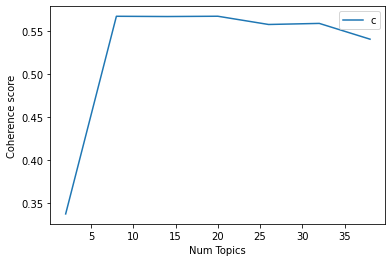

In [17]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, " has Coherence Value of", round(cv, 4))


Num Topics =  2  has Coherence Value of 0.3373
Num Topics =  8  has Coherence Value of 0.5675
Num Topics =  14  has Coherence Value of 0.5672
Num Topics =  20  has Coherence Value of 0.5675
Num Topics =  26  has Coherence Value of 0.5579
Num Topics =  32  has Coherence Value of 0.5592
Num Topics =  38  has Coherence Value of 0.5408


In [19]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.036*"year" + 0.028*"rise" + 0.018*"fall" + 0.018*"month" + '
  '0.018*"economy" + 0.016*"growth" + 0.014*"price" + 0.014*"high" + '
  '0.013*"figure" + 0.012*"increase"'),
 (1,
  '0.035*"england" + 0.022*"wale" + 0.017*"game" + 0.017*"ireland" + '
  '0.016*"france" + 0.013*"win" + 0.013*"side" + 0.013*"play" + 0.012*"player" '
  '+ 0.012*"scotland"'),
 (2,
  '0.020*"court" + 0.017*"case" + 0.016*"claim" + 0.015*"charge" + 0.013*"mr" '
  '+ 0.010*"face" + 0.009*"drug" + 0.008*"legal" + 0.008*"official" + '
  '0.008*"decision"'),
 (3,
  '0.019*"government" + 0.016*"mr" + 0.015*"bill" + 0.011*"issue" + '
  '0.011*"law" + 0.011*"lord" + 0.010*"plan" + 0.009*"power" + 0.009*"british" '
  '+ 0.009*"decision"'),
 (4,
  '0.026*"club" + 0.017*"play" + 0.016*"player" + 0.014*"game" + '
  '0.013*"manager" + 0.012*"team" + 0.011*"chelsea" + 0.010*"football" + '
  '0.010*"liverpool" + 0.009*"make"'),
 (5,
  '0.061*"show" + 0.021*"tv" + 0.018*"bbc" + 0.014*"series" + 0.014*"book" + '
  '0.

In [20]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.4076,"software, site, user, people, information, sec...",More women turn to net security Older people a...
1,1,10.0,0.3885,"people, mobile, service, technology, music, ph...",Souped-up wi-fi is on the horizon Super high-s...
2,2,14.0,0.4962,"software, site, user, people, information, sec...",Security scares spark browser fix Microsoft is...
3,3,10.0,0.5112,"people, mobile, service, technology, music, ph...","Lifestyle governs mobile choice Faster, better..."
4,4,8.0,0.2785,"year, number, top, record, include, release, s...",Fast lifts rise into record books Two high-spe...
5,5,14.0,0.4738,"software, site, user, people, information, sec...","Rich pickings for hi-tech thieves Viruses, tro..."
6,6,16.0,0.2631,"government, people, work, pay, plan, child, sc...",Online commons to spark debate Online communit...
7,7,11.0,0.6266,"game, play, computer, technology, time, world,...",Intel unveils laser breakthrough Intel has unv...
8,8,10.0,0.2525,"people, mobile, service, technology, music, ph...",Learning to love broadband We are reaching the...
9,9,11.0,0.5122,"game, play, computer, technology, time, world,...",What high-definition will do to DVDs First it ...


In [21]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6332,"year, rise, fall, month, economy, growth, pric...",House prices rebound says Halifax UK house pri...
1,1.0,0.6944,"england, wale, game, ireland, france, win, sid...",Harinordoquy suffers France axe Number eight I...
2,2.0,0.6407,"court, case, claim, charge, mr, face, drug, le...",Greek pair attend drugs hearing Greek sprinter...
3,3.0,0.6587,"government, mr, bill, issue, law, lord, plan, ...",Lords wrong on detainees - Straw Jack Straw ha...
4,4.0,0.6484,"club, play, player, game, manager, team, chels...",Yeading face Newcastle in FA Cup Premiership s...


In [22]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,14.0,"software, site, user, people, information, sec...",157.0,0.0706
1.0,10.0,"people, mobile, service, technology, music, ph...",137.0,0.0616
2.0,14.0,"software, site, user, people, information, sec...",101.0,0.0454
3.0,10.0,"people, mobile, service, technology, music, ph...",96.0,0.0432
4.0,8.0,"year, number, top, record, include, release, s...",154.0,0.0692
...,...,...,...,...
2219.0,6.0,"company, firm, share, profit, business, bank, ...",NaN,NaN
2220.0,0.0,"year, rise, fall, month, economy, growth, pric...",NaN,NaN
2221.0,16.0,"government, people, work, pay, plan, child, sc...",NaN,NaN
2222.0,0.0,"year, rise, fall, month, economy, growth, pric...",NaN,NaN
